<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 2</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

In [4]:
import os
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

np.random.seed(42)

In [5]:
# Paths
data_folder_name = "Data"
subject_folder_name = "s2"
subject_data_name = "S2_A1_E1.mat"

subject_data_path = os.path.join(data_folder_name, subject_folder_name,subject_data_name)

In [9]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition

mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)] 
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

## 1. Visualize & preprocess

In [6]:
data_folder_name = "Data"
subject_folders = sorted([folder for folder in os.listdir(data_folder_name) if folder != "s2"])
subject_files = []

mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

subjects = {}

for folder in subject_folders:
    folder_path = os.path.join(data_folder_name, folder)

    # Find all *_E1.mat files in this subject folder
    mat_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith('e1.mat')
    ]

    if not mat_files:
        print(f"No E1 file found in {folder_path}, skipping.")
        continue

    # Assuming exactly one E1 file per subject; take the first
    mat_file = mat_files[0]
    path = os.path.join(folder_path, mat_file)

    data = loadmat(path)

    print('\nSubject folder:', folder)
    print('File:', mat_file)
    print('Dataset variables:')
    for key in data.keys():
        if not key.startswith('__'):
            print(' ', key)

    # variables named as in your notebook
    emg = data['emg']                          # shape: (T, n_channels)
    stimulus = data['restimulus'].ravel()      # corrected labels (1D)
    repetition = data['rerepetition'].ravel()  # corrected repetition indices (1D)

    print(f"EMG data dimension : {emg.shape}")
    print(f"EMG data type : {type(emg)}")

    # number of movements and repetitions (excluding label 0 = rest)
    n_stimuli = len(np.unique(stimulus)) - 1
    n_repetitions = len(np.unique(repetition)) - 1

    emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
    emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(
                stimulus == (stimuli_idx + 1),
                repetition == (repetition_idx + 1)
            )

            if not np.any(idx):
                continue  # no samples for this (movement, repetition) pair

            window = emg[idx, :]

            # (optional) you could call a preprocessing here (e.g., filtered & rectified)
            # window = preprocess_emg(window, fs)  # if you define such a function

            emg_windows[stimuli_idx][repetition_idx] = window
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(
                window,
                mov_mean_weights,
                axis=0,
                mode="nearest"
            )

    # store everything
    subjects[folder] = {
        'emg': emg,
        'stimulus': stimulus,
        'repetition': repetition,
        'emg_windows': emg_windows,
        'emg_envelopes': emg_envelopes,
        'n_stimuli': n_stimuli,
        'n_repetitions': n_repetitions,
    }



Subject folder: s1
File: S1_A1_E1.mat
Dataset variables:
  emg
  stimulus
  glove
  subject
  exercise
  repetition
  restimulus
  rerepetition
EMG data dimension : (101014, 10)
EMG data type : <class 'numpy.ndarray'>

Subject folder: s10
File: S10_A1_E1.mat
Dataset variables:
  subject
  exercise
  stimulus
  emg
  glove
  restimulus
  repetition
  rerepetition
EMG data dimension : (100778, 10)
EMG data type : <class 'numpy.ndarray'>

Subject folder: s11
File: S11_A1_E1.mat
Dataset variables:
  subject
  exercise
  stimulus
  emg
  glove
  restimulus
  repetition
  rerepetition
EMG data dimension : (100899, 10)
EMG data type : <class 'numpy.ndarray'>

Subject folder: s12
File: S12_A1_E1.mat
Dataset variables:
  subject
  exercise
  stimulus
  emg
  glove
  restimulus
  repetition
  rerepetition
EMG data dimension : (100920, 10)
EMG data type : <class 'numpy.ndarray'>

Subject folder: s13
File: S13_A1_E1.mat
Dataset variables:
  subject
  exercise
  stimulus
  emg
  glove
  restimulus

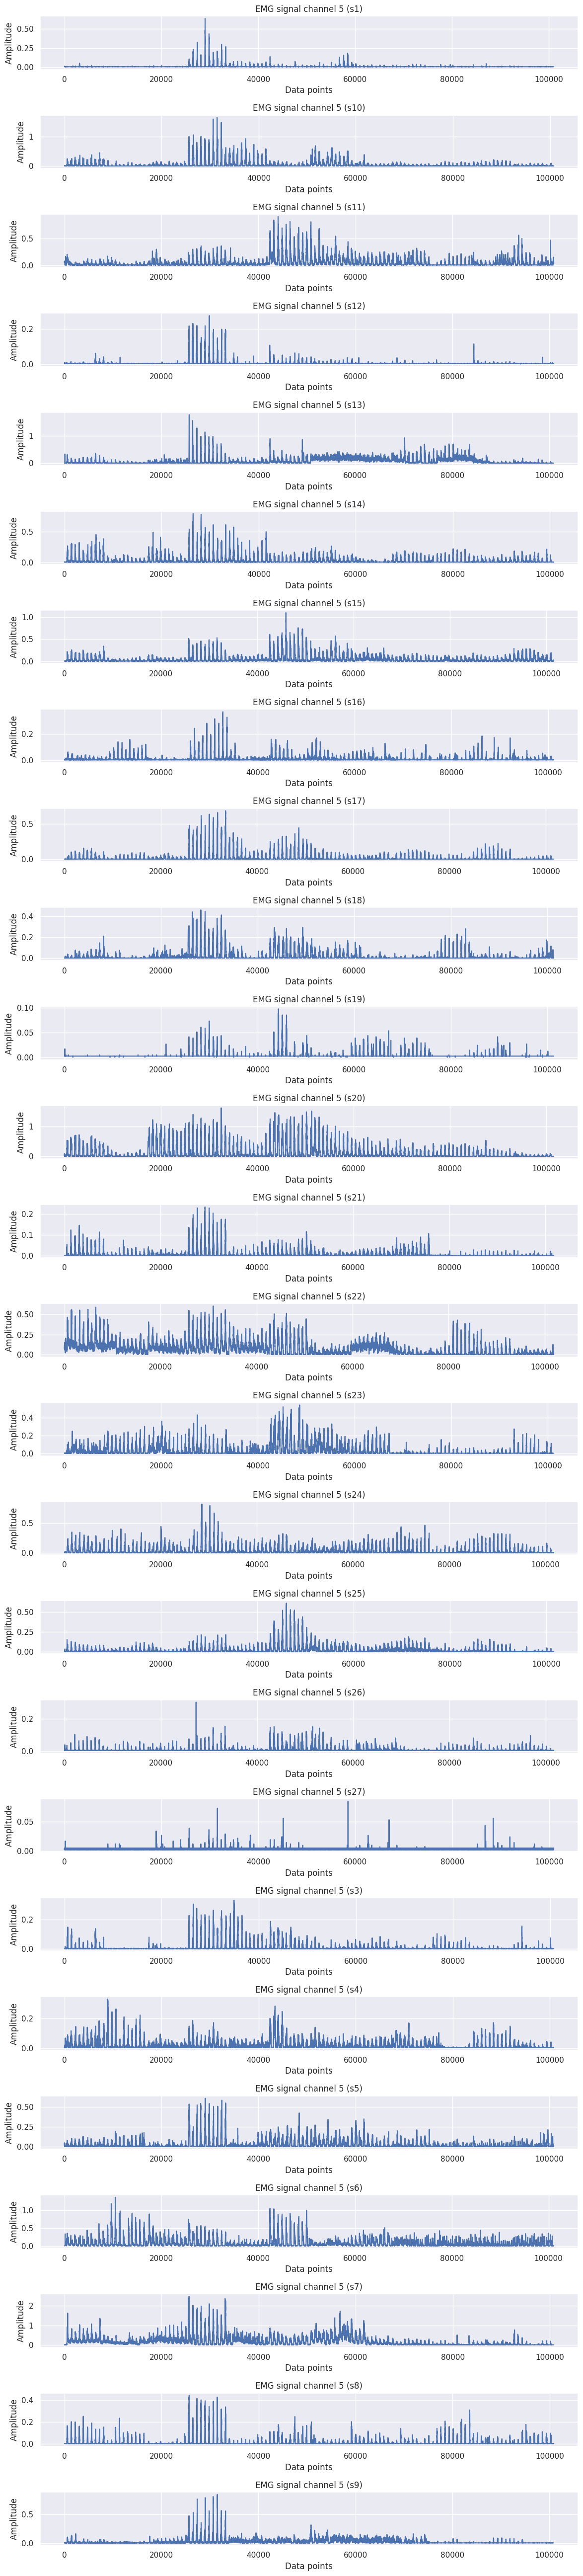

In [10]:
#plot first EMG channel for all 27 subjects
plt.close('all')
fig, axes = plt.subplots(len(subjects), 1, figsize=(12, 2*len(subjects)))

for idx, (fname, sub) in enumerate(subjects.items()):
    emg = sub['emg']
    EMG_channel = 5 if emg.shape[1] > 5 else 0
    axes[idx].plot(emg[:, EMG_channel])
    axes[idx].set_title(f"EMG signal channel {EMG_channel} ({fname})")
    axes[idx].set_xlabel('Data points')
    axes[idx].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## 2. Feature extraction & visualization

In [12]:
# Define the features (same lambdas as notebook)
mav = lambda x: np.mean(np.abs(x), axis=0)
std = lambda x: np.std(x, axis=0)
maxav = lambda x: np.max(np.abs(x), axis=0)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

# Choose features (default to the two used in the notebook)
features = [mav, std]

# Build dataset and labels per subject using the same function
subject_datasets = {}
for fname, sub in subjects.items():
    print('Building dataset for', fname)
    dataset, labels = build_dataset_from_ninapro(
        emg=sub['emg'],
        stimulus=sub['stimulus'],
        repetition=sub['repetition'],
        features=features
    )
    print(f"  dataset shape: {dataset.shape}, labels shape: {labels.shape}")
    subject_datasets[fname] = {'dataset': dataset, 'labels': labels}

Building dataset for s1
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s10
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s11
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s12
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s13
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s14
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s15
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s16
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s17
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s18
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s19
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s20
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s21
  dataset shape: (120, 20), labels shape: (120,)
Building dataset for s22
  dataset shap

## 4. Gradient boosting classification

In [13]:
# Train and evaluate a baseline model per subject

results = []

for fname, data_pair in subject_datasets.items():
    X = data_pair['dataset']
    y = data_pair['labels']
    print('\nTraining subject:', fname)
    # train/val/test split as in notebook
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=0
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0
    )

    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_val_z = scaler.transform(X_val)
    X_test_z = scaler.transform(X_test)

    gb = GradientBoostingClassifier(random_state=0)
    gb.fit(X_train_z, y_train)

    y_val_pred = gb.predict(X_val_z)
    print('  Baseline val accuracy:', accuracy_score(y_val, y_val_pred))
    print('  Baseline val macro-F1:', f1_score(y_val, y_val_pred, average='macro'))

    y_test_pred = gb.predict(X_test_z)
    baseline_acc = accuracy_score(y_test, y_test_pred)
    baseline_f1 = f1_score(y_test, y_test_pred, average='macro')
    print('  Test accuracy:', baseline_acc)
    print('  Test macro-F1:', baseline_f1)

    # Collect results
    results.append({
        'subject_file': fname,
        'baseline_acc': float(baseline_acc),
        'baseline_f1': float(baseline_f1),
    })



Training subject: s1
  Baseline val accuracy: 0.75
  Baseline val macro-F1: 0.7527777777777778
  Test accuracy: 0.7083333333333334
  Test macro-F1: 0.6892857142857144

Training subject: s10
  Baseline val accuracy: 0.9166666666666666
  Baseline val macro-F1: 0.911111111111111
  Test accuracy: 0.7916666666666666
  Test macro-F1: 0.7888888888888889

Training subject: s11
  Baseline val accuracy: 0.7916666666666666
  Baseline val macro-F1: 0.7916666666666665
  Test accuracy: 0.875
  Test macro-F1: 0.8722222222222222

Training subject: s12
  Baseline val accuracy: 0.625
  Baseline val macro-F1: 0.6194444444444445
  Test accuracy: 0.6666666666666666
  Test macro-F1: 0.6309523809523809

Training subject: s13
  Baseline val accuracy: 0.7083333333333334
  Baseline val macro-F1: 0.6531746031746032
  Test accuracy: 0.6666666666666666
  Test macro-F1: 0.6916666666666668

Training subject: s14
  Baseline val accuracy: 0.625
  Baseline val macro-F1: 0.6805555555555555
  Test accuracy: 0.7916666666